In the following code, we make CNN models in order to classify ASL Fingerspelling images from a Kaggle dataset.

In [100]:
import os
import numpy as np
import pandas as pd
import glob
from IPython.display import Image, display 
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [89]:
TestingList = []
im_directories = []
i = 0
for direct in os.listdir('/Users/noahlichtblau/Downloads/ASL-Fingerspelling'):
    i+=1
    if direct != '.DS_Store':
        im_directories.append(direct)


In [97]:
X = []
y = []
y_train = []
X_train = []
y_val = []
X_val = []
y_test = []
X_test = []
for person in im_directories:
    path = '/Users/noahlichtblau/Downloads/ASL-Fingerspelling/'+ person
    labels = os.listdir(path)
    for label in labels:
        i = 0
        if label != '.DS_Store':

            img_names = os.listdir(path+'/'+label)
            for img_name in img_names:
                if img_name != '.DS_Store':
                    if img_name.startswith('color'):
                        
                        # Reformatting image, changing to greyscale and sizing it to 32 X 32
                        img = Image.open(path+'/'+label+ '/'+img_name).convert('LA')
                        img_resized = img.resize((32,32))

                        X.append(np.array(img_resized))
                        y.append(label)
                        i = i+1
                    
                    # To prevent over sampling of one particular letter
                    if i > 750:
                        break


In [1]:
# Checking to confirm that 
# print(y)

In [99]:
X = np.array(X)
print(X.shape)
y = np.array(y)

(65774, 32, 32, 2)


In [6]:
X_std = X.astype('float32')/255

In [7]:
X_std.shape

(65589, 32, 32, 2)

In [10]:
from keras import models, layers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: F

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
y_train_coded = LabelEncoder().fit_transform(y)
print(y_train_coded)
y_train_coded = to_categorical(y_train_coded, num_classes=24, dtype='float32')
print(y_train_coded)

[ 0  0  0 ... 23 23 23]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [12]:
#let's take only 2000 samples of train data, 500 samples of val data and 200 samples of test data
r = np.arange(X_std.shape[0])
np.random.seed(42)
np.random.shuffle(r)
X_train = X_std[r]
X_train_data = X_train[:39353,:,:]
X_train_data = X_train_data.reshape((39353, 32, 32, 2))
y_train = y_train_coded[r]
y_train_data = y_train[:39353]
X_test_data = X_train[52472:,:,:]
X_test_data = X_test_data.reshape((13117, 32, 32, 2))
y_test_data = y_train[52472:]
X_val_data = X_train[39354:52471,:,:]
X_val_data = X_val_data.reshape((13117, 32, 32, 2))
y_val_data = y_train[39354:52471]

In [13]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_best = models.Sequential()
model_maxpool_best.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_best.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_best.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_best.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_best.add(layers.Dropout(rate = 0.25))
model_maxpool_best.add(layers.Flatten())
model_maxpool_best.add(layers.Dense(256, activation = 'relu'))
model_maxpool_best.add(layers.Dropout(rate = 0.5))
model_maxpool_best.add(layers.Dense(24, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# compile the model
model_maxpool_best.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [15]:
#fitting the model
history_maxpool_best = model_maxpool_best.fit(X_train_data, y_train_data, epochs=25, validation_data=(X_val_data, y_val_data))

Instructions for updating:
Use tf.cast instead.
Train on 39353 samples, validate on 13117 samples
Epoch 1/25
39353/39353 [==============================] - 52s 1ms/step - loss: 1.4769 - acc: 0.5478 - val_loss: 0.5578 - val_acc: 0.8407
Epoch 2/25
39353/39353 [==============================] - 50s 1ms/step - loss: 0.6906 - acc: 0.7816 - val_loss: 0.3195 - val_acc: 0.9094
Epoch 3/25
39353/39353 [==============================] - 52s 1ms/step - loss: 0.5235 - acc: 0.8311 - val_loss: 0.2487 - val_acc: 0.9265
Epoch 4/25
39353/39353 [==============================] - 59s 1ms/step - loss: 0.4338 - acc: 0.8583 - val_loss: 0.1731 - val_acc: 0.9501
Epoch 5/25
39353/39353 [==============================] - 54s 1ms/step - loss: 0.3759 - acc: 0.8771 - val_loss: 0.1409 - val_acc: 0.9584
Epoch 6/25
39353/39353 [==============================] - 49s 1ms/step - loss: 0.3339 - acc: 0.8902 - val_loss: 0.1268 - val_acc: 0.9643
Epoch 7/25
39353/39353 [==============================] - 56s 1ms/step - loss: 0

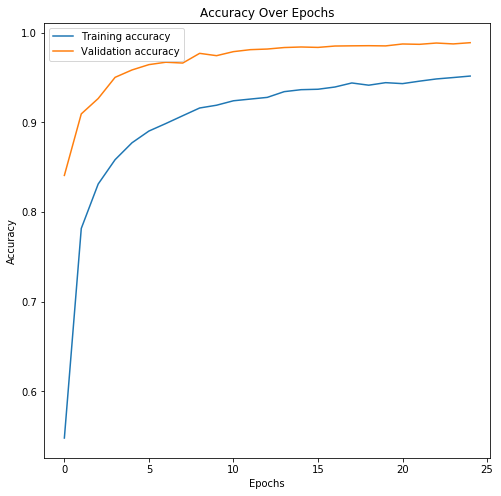

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,8))
plt.plot(history_maxpool_best.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_best.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

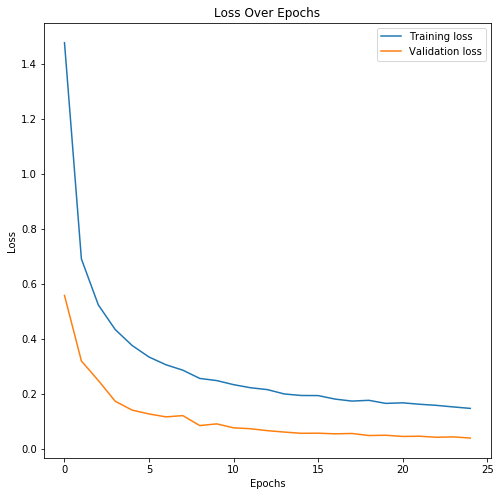

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,8))
plt.plot(history_maxpool_best.history['loss'], label='Training loss')
plt.plot(history_maxpool_best.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
y_pred_maxpool_best = model_maxpool_best.predict_classes(X_test_data)
y_test_maxpool_best = np.argmax(y_test_data, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_best = accuracy_score(y_pred_maxpool_best,y_test_maxpool_best)
print('the accuracy obtained on the test set is:', accuracy_maxpool_best)

the accuracy obtained on the test set is: 0.9878783258367004


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_best, y_pred_maxpool_best))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       558
          1       0.99      1.00      1.00       518
          2       1.00      0.99      1.00       584
          3       0.99      0.99      0.99       518
          4       0.99      0.99      0.99       542
          5       0.99      1.00      1.00       521
          6       0.99      0.98      0.98       546
          7       0.98      0.98      0.98       502
          8       0.99      1.00      1.00       534
          9       0.99      0.99      0.99       563
         10       0.99      1.00      1.00       550
         11       0.98      0.99      0.99       524
         12       0.99      0.97      0.98       550
         13       1.00      0.99      0.99       561
         14       0.98      0.99      0.98       554
         15       0.99      0.99      0.99       553
         16       0.96      0.98      0.97       576
         17       0.98      0.99      0.99   

In [20]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_no_dropout = models.Sequential()
model_maxpool_no_dropout.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_no_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_no_dropout.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_no_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_no_dropout.add(layers.Flatten())
model_maxpool_no_dropout.add(layers.Dense(256, activation = 'relu'))
model_maxpool_no_dropout.add(layers.Dense(24, activation = 'softmax'))

In [21]:
# compile the model
model_maxpool_no_dropout.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [22]:
#fitting the model
history_maxpool_no_dropout = model_maxpool_no_dropout.fit(X_train_data, y_train_data, epochs=25, validation_data=(X_val_data, y_val_data))

Train on 39353 samples, validate on 13117 samples
Epoch 1/25
39353/39353 [==============================] - 50s 1ms/step - loss: 1.0177 - acc: 0.6944 - val_loss: 0.4499 - val_acc: 0.8635
Epoch 2/25
39353/39353 [==============================] - 49s 1ms/step - loss: 0.2897 - acc: 0.9110 - val_loss: 0.2133 - val_acc: 0.9364
Epoch 3/25
39353/39353 [==============================] - 54s 1ms/step - loss: 0.1586 - acc: 0.9501 - val_loss: 0.1923 - val_acc: 0.9389
Epoch 4/25
39353/39353 [==============================] - 51s 1ms/step - loss: 0.1022 - acc: 0.9669 - val_loss: 0.1660 - val_acc: 0.9508
Epoch 5/25
39353/39353 [==============================] - 64s 2ms/step - loss: 0.0774 - acc: 0.9751 - val_loss: 0.1186 - val_acc: 0.9639
Epoch 6/25
39353/39353 [==============================] - 54s 1ms/step - loss: 0.0529 - acc: 0.9831 - val_loss: 0.1317 - val_acc: 0.9636
Epoch 7/25
39353/39353 [==============================] - 48s 1ms/step - loss: 0.0507 - acc: 0.9835 - val_loss: 0.1183 - val_acc

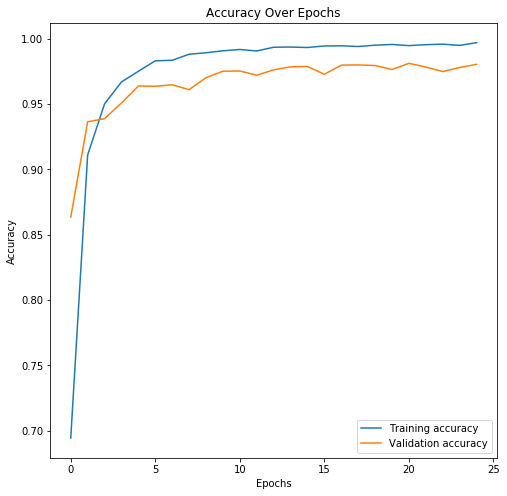

In [115]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_no_dropout.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_no_dropout.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

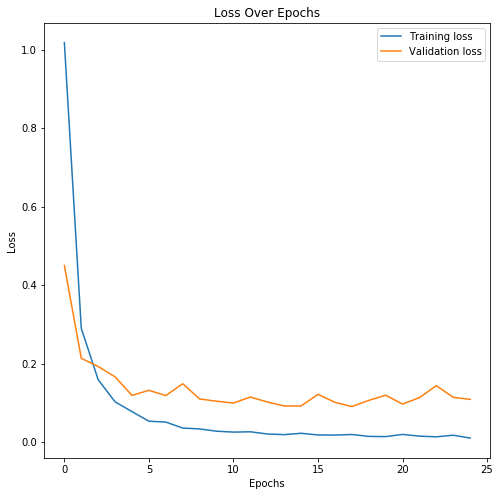

In [104]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_no_dropout.history['loss'], label='Training loss')
plt.plot(history_maxpool_no_dropout.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
y_pred_maxpool_no_dropout = model_maxpool_no_dropout.predict_classes(X_test_data)
y_test_maxpool_no_dropout = np.argmax(y_test_data, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_no_dropout = accuracy_score(y_pred_maxpool_no_dropout,y_test_maxpool_no_dropout)
print('the accuracy obtained on the test set is:', accuracy_maxpool_no_dropout)

the accuracy obtained on the test set is: 0.9815506594495692


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_no_dropout, y_pred_maxpool_no_dropout))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       558
          1       0.99      0.99      0.99       518
          2       1.00      1.00      1.00       584
          3       0.99      0.99      0.99       518
          4       0.99      0.98      0.98       542
          5       0.99      0.99      0.99       521
          6       0.99      0.98      0.98       546
          7       0.99      0.97      0.98       502
          8       0.98      0.98      0.98       534
          9       0.96      0.99      0.97       563
         10       0.99      1.00      0.99       550
         11       0.98      0.97      0.98       524
         12       0.96      0.99      0.97       550
         13       1.00      0.98      0.99       561
         14       0.97      0.98      0.97       554
         15       0.97      0.97      0.97       553
         16       0.95      0.98      0.96       576
         17       0.97      0.99      0.98   

In [27]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_too_much_dropout = models.Sequential()
model_maxpool_too_much_dropout.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_too_much_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_too_much_dropout.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_too_much_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_too_much_dropout.add(layers.Dropout(rate = 0.8))
model_maxpool_too_much_dropout.add(layers.Flatten())
model_maxpool_too_much_dropout.add(layers.Dense(256, activation = 'relu'))
model_maxpool_too_much_dropout.add(layers.Dropout(rate = 0.8))
model_maxpool_too_much_dropout.add(layers.Dense(24, activation = 'softmax'))

In [28]:
# compile the model
model_maxpool_too_much_dropout.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [29]:
#fitting the model
history_maxpool_too_much_dropout = model_maxpool_too_much_dropout.fit(X_train_data, y_train_data, epochs=25, validation_data=(X_val_data, y_val_data))

Train on 39353 samples, validate on 13117 samples
Epoch 1/25
39353/39353 [==============================] - 62s 2ms/step - loss: 2.4859 - acc: 0.2388 - val_loss: 1.4072 - val_acc: 0.6242
Epoch 2/25
39353/39353 [==============================] - 57s 1ms/step - loss: 1.7990 - acc: 0.4315 - val_loss: 1.2331 - val_acc: 0.6975
Epoch 3/25
39353/39353 [==============================] - 60s 2ms/step - loss: 1.6058 - acc: 0.4889 - val_loss: 0.9783 - val_acc: 0.7482
Epoch 4/25
39353/39353 [==============================] - 48s 1ms/step - loss: 1.4877 - acc: 0.5195 - val_loss: 0.8827 - val_acc: 0.7769
Epoch 5/25
39353/39353 [==============================] - 47s 1ms/step - loss: 1.4080 - acc: 0.5477 - val_loss: 0.8002 - val_acc: 0.8068
Epoch 6/25
39353/39353 [==============================] - 48s 1ms/step - loss: 1.3391 - acc: 0.5685 - val_loss: 0.7770 - val_acc: 0.8079
Epoch 7/25
39353/39353 [==============================] - 47s 1ms/step - loss: 1.3035 - acc: 0.5789 - val_loss: 0.6909 - val_acc

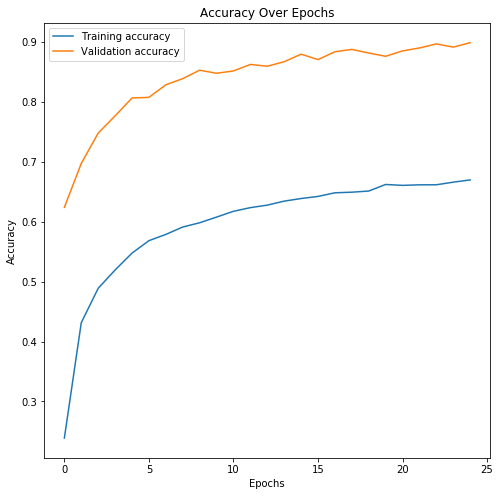

In [116]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_too_much_dropout.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_too_much_dropout.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

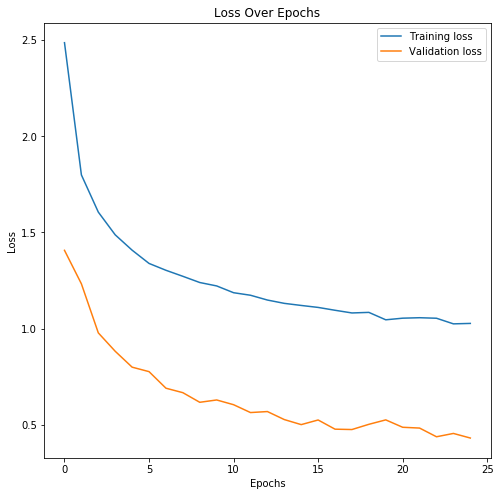

In [117]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_too_much_dropout.history['loss'], label='Training loss')
plt.plot(history_maxpool_too_much_dropout.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
y_pred_maxpool_too_much_dropout = model_maxpool_too_much_dropout.predict_classes(X_test_data)
y_test_maxpool_too_much_dropout = np.argmax(y_test_data, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_too_much_dropout = accuracy_score(y_pred_maxpool_too_much_dropout,y_test_maxpool_too_much_dropout)
print('the accuracy obtained on the test set is:', accuracy_maxpool_too_much_dropout)

the accuracy obtained on the test set is: 0.897994968361668


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_too_much_dropout, y_pred_maxpool_too_much_dropout))

             precision    recall  f1-score   support

          0       0.88      0.93      0.90       558
          1       0.96      0.99      0.98       518
          2       1.00      0.93      0.96       584
          3       0.95      0.70      0.80       518
          4       0.90      0.95      0.93       542
          5       0.99      0.97      0.98       521
          6       0.91      0.72      0.81       546
          7       0.76      0.97      0.85       502
          8       0.92      0.96      0.94       534
          9       0.94      0.89      0.91       563
         10       0.94      0.99      0.96       550
         11       0.76      0.97      0.85       524
         12       0.92      0.80      0.86       550
         13       0.95      0.81      0.88       561
         14       0.88      0.88      0.88       554
         15       0.87      0.94      0.90       553
         16       0.71      0.92      0.80       576
         17       0.90      0.92      0.91   

In [34]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_1 = models.Sequential()
model_maxpool_1.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_1.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_1.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_1.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_1.add(layers.Dropout(rate = 0.5))
model_maxpool_1.add(layers.Flatten())
model_maxpool_1.add(layers.Dense(256, activation = 'relu'))
model_maxpool_1.add(layers.Dropout(rate = 0.25))
model_maxpool_1.add(layers.Dense(24, activation = 'softmax'))

In [35]:
# compile the model
model_maxpool_1.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [36]:
history_maxpool_1 = model_maxpool_1.fit(X_train_data, y_train_data, epochs=25, validation_data=(X_val_data, y_val_data))

Train on 39353 samples, validate on 13117 samples
Epoch 1/25
39353/39353 [==============================] - 91s 2ms/step - loss: 1.3154 - acc: 0.5935 - val_loss: 0.4714 - val_acc: 0.8612
Epoch 2/25
39353/39353 [==============================] - 86s 2ms/step - loss: 0.5611 - acc: 0.8205 - val_loss: 0.2436 - val_acc: 0.9315
Epoch 3/25
39353/39353 [==============================] - 94s 2ms/step - loss: 0.3968 - acc: 0.8735 - val_loss: 0.1743 - val_acc: 0.9516
Epoch 4/25
39353/39353 [==============================] - 66s 2ms/step - loss: 0.3178 - acc: 0.8983 - val_loss: 0.1661 - val_acc: 0.9510
Epoch 5/25
39353/39353 [==============================] - 50s 1ms/step - loss: 0.2692 - acc: 0.9123 - val_loss: 0.0970 - val_acc: 0.9726
Epoch 6/25
39353/39353 [==============================] - 62s 2ms/step - loss: 0.2454 - acc: 0.9205 - val_loss: 0.0897 - val_acc: 0.9732
Epoch 7/25
39353/39353 [==============================] - 85s 2ms/step - loss: 0.2150 - acc: 0.9281 - val_loss: 0.0818 - val_acc

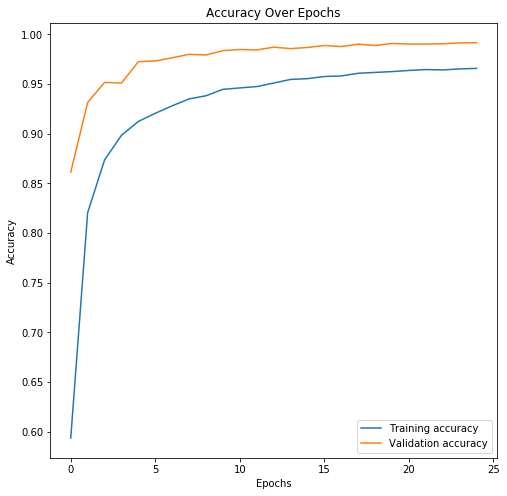

In [118]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_1.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_1.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

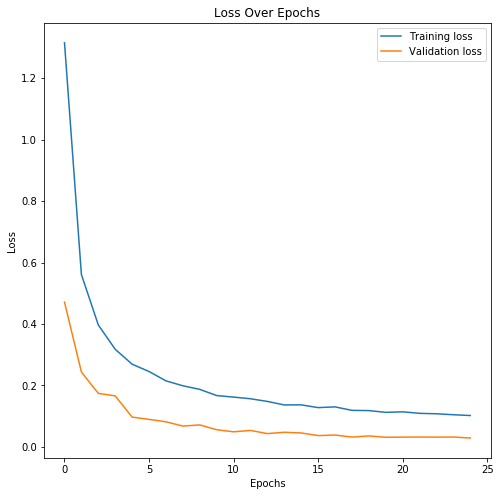

In [119]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_1.history['loss'], label='Training loss')
plt.plot(history_maxpool_1.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
y_pred_maxpool_1 = model_maxpool_1.predict_classes(X_test_data)
y_test_maxpool_1 = np.argmax(y_test_data, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_1 = accuracy_score(y_pred_maxpool_1,y_test_maxpool_1)
print('the accuracy obtained on the test set is:', accuracy_maxpool_1)

the accuracy obtained on the test set is: 0.9909278036136312


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_1, y_pred_maxpool_1))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       558
          1       1.00      1.00      1.00       518
          2       1.00      1.00      1.00       584
          3       1.00      1.00      1.00       518
          4       0.99      1.00      0.99       542
          5       0.99      1.00      1.00       521
          6       0.97      0.98      0.98       546
          7       0.98      0.98      0.98       502
          8       1.00      1.00      1.00       534
          9       0.99      0.99      0.99       563
         10       0.99      1.00      1.00       550
         11       0.99      0.98      0.99       524
         12       0.99      0.98      0.99       550
         13       0.99      0.99      0.99       561
         14       0.99      0.99      0.99       554
         15       0.99      0.99      0.99       553
         16       0.98      0.98      0.98       576
         17       0.99      1.00      0.99   

In [45]:
#Getting training data the correct way
image_directories = []
i = 0
for direct in os.listdir('/Users/noahlichtblau/Downloads/ASL-Fingerspelling'):
    i+=1
    if direct != '.DS_Store':
        image_directories.append(direct)


In [50]:
X = []
y = []
y_train = []
X_train = []
y_val = []
X_val = []
y_test = []
X_test = []
for person in im_directories[:3]:
    path = '/Users/noahlichtblau/Downloads/ASL-Fingerspelling/'+ person
    labels = os.listdir(path)
    for label in labels:
        i = 0
        if label != '.DS_Store':

            img_names = os.listdir(path+'/'+label)
            for img_name in img_names:
                if img_name != '.DS_Store':
                    if img_name.startswith('color'):
                        img = Image.open(path+'/'+label+ '/'+img_name).convert('LA')
                        img_resized = img.resize((32,32))
                        X_train.append(np.array(img_resized))
                        y_train.append(label)
                        i = i+1
                    if i > 750:
                        break

for person in im_directories[3]:
    path = '/Users/noahlichtblau/Downloads/ASL-Fingerspelling/'+ person
    labels = os.listdir(path)
    for label in labels:
        i = 0
        if label != '.DS_Store':

            img_names = os.listdir(path+'/'+label)
            for img_name in img_names:
                if img_name != '.DS_Store':
                    if img_name.startswith('color'):
                        img = Image.open(path+'/'+label+ '/'+img_name).convert('LA')
                        img_resized = img.resize((32,32))
                        X_val.append(np.array(img_resized))
                        y_val.append(label)
                        i = i+1
                    if i > 750:
                        break
                        
for person in im_directories[4]:
    path = '/Users/noahlichtblau/Downloads/ASL-Fingerspelling/'+ person
    labels = os.listdir(path)
    for label in labels:
        i = 0
        if label != '.DS_Store':

            img_names = os.listdir(path+'/'+label)
            for img_name in img_names:
                if img_name != '.DS_Store':
                    if img_name.startswith('color'):
                        img = Image.open(path+'/'+label+ '/'+img_name).convert('LA')
                        img_resized = img.resize((32,32))
                        #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        #img_resized = cv2.resize(img_gray, (32,32))
                        X_test.append(np.array(img_resized))
                        y_test.append(label)
                        i = i+1
                    if i > 750:
                        break

In [52]:
X_train = np.array(X_train)
print(X_train.shape)
y_train = np.array(y_train)
X_val = np.array(X_val)
print(X_val.shape)
y_val = np.array(y_val)
X_test = np.array(X_test)
print(X_test.shape)
y_test = np.array(y_test)

(39675, 32, 32, 2)
(13132, 32, 32, 2)
(12782, 32, 32, 2)


In [53]:
X_train_std = X_train.astype('float32')/255
X_val_std = X_val.astype('float32')/255
X_test_std = X_test.astype('float32')/255

In [55]:
y_train_coded = LabelEncoder().fit_transform(y_train)
print(y_train_coded)
y_train_coded = to_categorical(y_train_coded, num_classes=24, dtype='float32')
print(y_train_coded)
y_val_coded = LabelEncoder().fit_transform(y_val)
print(y_val_coded)
y_val_coded = to_categorical(y_val_coded, num_classes=24, dtype='float32')
print(y_val_coded)
y_test_coded = LabelEncoder().fit_transform(y_test)
print(y_test_coded)
y_test_coded = to_categorical(y_test_coded, num_classes=24, dtype='float32')
print(y_test_coded)

[ 0  0  0 ... 23 23 23]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[ 0  0  0 ... 23 23 23]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[ 0  0  0 ... 23 23 23]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [56]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_people_1 = models.Sequential()
model_maxpool_people_1.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_people_1.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_people_1.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_people_1.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_people_1.add(layers.Dropout(rate = 0.5))
model_maxpool_people_1.add(layers.Flatten())
model_maxpool_people_1.add(layers.Dense(256, activation = 'relu'))
model_maxpool_people_1.add(layers.Dropout(rate = 0.25))
model_maxpool_people_1.add(layers.Dense(24, activation = 'softmax'))

In [57]:
# compile the model
model_maxpool_people_1.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [59]:
history_maxpool_people_1 = model_maxpool_people_1.fit(X_train_std, y_train_coded, epochs=25, validation_data=(X_val_std, y_val_coded))

Train on 39675 samples, validate on 13132 samples
Epoch 1/25
39675/39675 [==============================] - 51s 1ms/step - loss: 1.0185 - acc: 0.6882 - val_loss: 3.9576 - val_acc: 0.1863
Epoch 2/25
39675/39675 [==============================] - 51s 1ms/step - loss: 0.3612 - acc: 0.8825 - val_loss: 3.7700 - val_acc: 0.2164
Epoch 3/25
39675/39675 [==============================] - 51s 1ms/step - loss: 0.2536 - acc: 0.9168 - val_loss: 4.1105 - val_acc: 0.2348
Epoch 4/25
39675/39675 [==============================] - 49s 1ms/step - loss: 0.1975 - acc: 0.9353 - val_loss: 4.4306 - val_acc: 0.2162
Epoch 5/25
39675/39675 [==============================] - 51s 1ms/step - loss: 0.1735 - acc: 0.9425 - val_loss: 4.6693 - val_acc: 0.2002
Epoch 6/25
39675/39675 [==============================] - 51s 1ms/step - loss: 0.1491 - acc: 0.9514 - val_loss: 5.3355 - val_acc: 0.2010
Epoch 7/25
39675/39675 [==============================] - 74s 2ms/step - loss: 0.1316 - acc: 0.9567 - val_loss: 5.2879 - val_acc

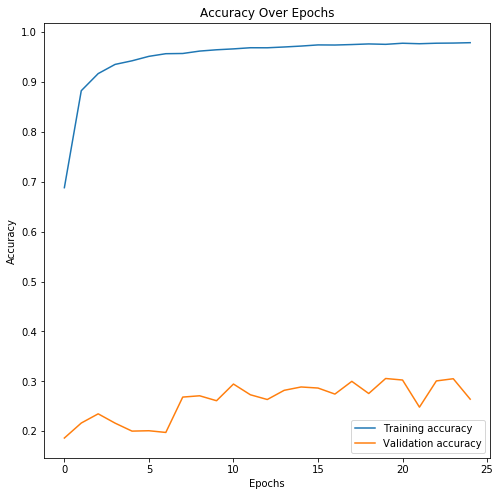

In [120]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_1.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_people_1.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

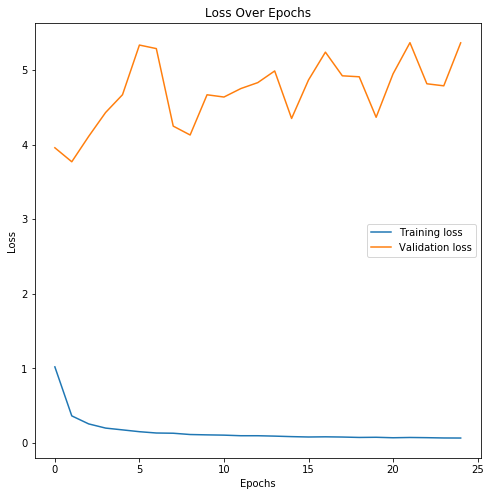

In [121]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_1.history['loss'], label='Training loss')
plt.plot(history_maxpool_people_1.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
y_pred_maxpool_people_1 = model_maxpool_people_1.predict_classes(X_test_std)
y_test_maxpool_people_1 = np.argmax(y_test_coded, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_people_1 = accuracy_score(y_pred_maxpool_people_1,y_test_maxpool_people_1)
print('the accuracy obtained on the test set is:', accuracy_maxpool_people_1)

the accuracy obtained on the test set is: 0.5830073540916915


In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_people_1, y_pred_maxpool_people_1))

             precision    recall  f1-score   support

          0       0.75      0.77      0.76       545
          1       0.59      0.99      0.74       534
          2       0.63      0.86      0.73       540
          3       0.60      0.77      0.67       544
          4       0.25      0.15      0.18       539
          5       0.68      0.83      0.75       527
          6       0.67      0.75      0.71       537
          7       0.85      0.64      0.73       534
          8       0.88      0.57      0.69       525
          9       0.83      0.32      0.46       569
         10       0.79      0.68      0.73       514
         11       0.50      0.59      0.54       525
         12       0.62      0.75      0.68       530
         13       0.47      0.42      0.44       532
         14       0.88      0.69      0.78       527
         15       0.69      0.16      0.26       529
         16       0.09      0.06      0.07       562
         17       0.52      0.51      0.51   

In [65]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_people_2 = models.Sequential()
model_maxpool_people_2.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_people_2.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_people_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_people_2.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_people_2.add(layers.Dropout(rate = 0.25))
model_maxpool_people_2.add(layers.Flatten())
model_maxpool_people_2.add(layers.Dense(256, activation = 'relu'))
model_maxpool_people_2.add(layers.Dropout(rate = 0.5))
model_maxpool_people_2.add(layers.Dense(24, activation = 'softmax'))

In [66]:
# compile the model
model_maxpool_people_2.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [67]:
history_maxpool_people_2 = model_maxpool_people_2.fit(X_train_std, y_train_coded, epochs=25, validation_data=(X_val_std, y_val_coded))

Train on 39675 samples, validate on 13132 samples
Epoch 1/25
39675/39675 [==============================] - 62s 2ms/step - loss: 1.1252 - acc: 0.6550 - val_loss: 3.6886 - val_acc: 0.1791
Epoch 2/25
39675/39675 [==============================] - 51s 1ms/step - loss: 0.4198 - acc: 0.8658 - val_loss: 4.0397 - val_acc: 0.2029
Epoch 3/25
39675/39675 [==============================] - 49s 1ms/step - loss: 0.2829 - acc: 0.9074 - val_loss: 4.0534 - val_acc: 0.2205
Epoch 4/25
39675/39675 [==============================] - 49s 1ms/step - loss: 0.2226 - acc: 0.9270 - val_loss: 5.0047 - val_acc: 0.2094
Epoch 5/25
39675/39675 [==============================] - 50s 1ms/step - loss: 0.1817 - acc: 0.9393 - val_loss: 4.8095 - val_acc: 0.2211
Epoch 6/25
39675/39675 [==============================] - 49s 1ms/step - loss: 0.1479 - acc: 0.9512 - val_loss: 4.9793 - val_acc: 0.2234
Epoch 7/25
39675/39675 [==============================] - 58s 1ms/step - loss: 0.1276 - acc: 0.9559 - val_loss: 4.7747 - val_acc

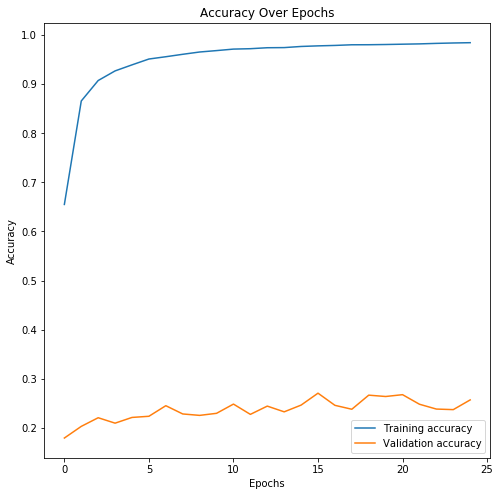

In [124]:

plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_2.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_people_2.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

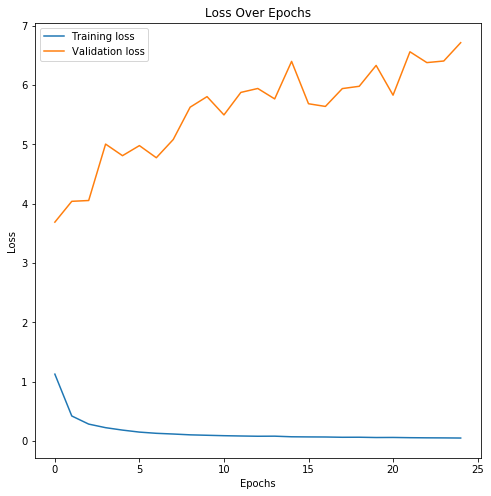

In [122]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_2.history['loss'], label='Training loss')
plt.plot(history_maxpool_people_2.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
y_pred_maxpool_people_2 = model_maxpool_people_2.predict_classes(X_test_std)
y_test_maxpool_people_2 = np.argmax(y_test_coded, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_people_2 = accuracy_score(y_pred_maxpool_people_2,y_test_maxpool_people_2)
print('the accuracy obtained on the test set is:', accuracy_maxpool_people_2)

the accuracy obtained on the test set is: 0.5960726020966984


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_people_2, y_pred_maxpool_people_2))

             precision    recall  f1-score   support

          0       0.56      0.75      0.64       545
          1       0.69      0.99      0.81       534
          2       0.47      0.90      0.61       540
          3       0.70      0.71      0.71       544
          4       0.24      0.12      0.16       539
          5       0.87      0.94      0.91       527
          6       0.64      0.74      0.68       537
          7       0.95      0.50      0.66       534
          8       0.81      0.70      0.75       525
          9       0.81      0.19      0.31       569
         10       0.79      0.82      0.81       514
         11       0.63      0.69      0.66       525
         12       0.50      0.67      0.57       530
         13       0.39      0.38      0.39       532
         14       0.93      0.63      0.75       527
         15       0.42      0.07      0.11       529
         16       0.26      0.18      0.21       562
         17       0.63      0.64      0.63   

In [72]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_people_too_much_dropout = models.Sequential()
model_maxpool_people_too_much_dropout.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_people_too_much_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_people_too_much_dropout.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_people_too_much_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_people_too_much_dropout.add(layers.Dropout(rate = 0.8))
model_maxpool_people_too_much_dropout.add(layers.Flatten())
model_maxpool_people_too_much_dropout.add(layers.Dense(256, activation = 'relu'))
model_maxpool_people_too_much_dropout.add(layers.Dropout(rate = 0.8))
model_maxpool_people_too_much_dropout.add(layers.Dense(24, activation = 'softmax'))

In [ ]:
# compile the model
model_maxpool_people_too_much_dropout.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [ ]:
history_maxpool_people_too_much_dropout = model_maxpool_people_too_much_dropout.fit(X_train_std, y_train_coded, epochs=25, validation_data=(X_val_std, y_val_coded))

Train on 39675 samples, validate on 13132 samples
Epoch 1/25
39675/39675 [==============================] - 59s 1ms/step - loss: 2.2630 - acc: 0.3029 - val_loss: 3.1826 - val_acc: 0.1642
Epoch 2/25
39675/39675 [==============================] - 48s 1ms/step - loss: 1.4784 - acc: 0.5331 - val_loss: 3.2310 - val_acc: 0.1770
Epoch 3/25
39675/39675 [==============================] - 48s 1ms/step - loss: 1.2954 - acc: 0.5916 - val_loss: 3.3177 - val_acc: 0.1828
Epoch 4/25
39675/39675 [==============================] - 49s 1ms/step - loss: 1.1884 - acc: 0.6240 - val_loss: 3.0790 - val_acc: 0.2081
Epoch 5/25
39675/39675 [==============================] - 48s 1ms/step - loss: 1.1201 - acc: 0.6451 - val_loss: 2.8479 - val_acc: 0.2225
Epoch 6/25
39675/39675 [==============================] - 49s 1ms/step - loss: 1.0677 - acc: 0.6626 - val_loss: 3.2022 - val_acc: 0.1927
Epoch 7/25
39675/39675 [==============================] - 48s 1ms/step - loss: 1.0181 - acc: 0.6772 - val_loss: 2.7738 - val_acc

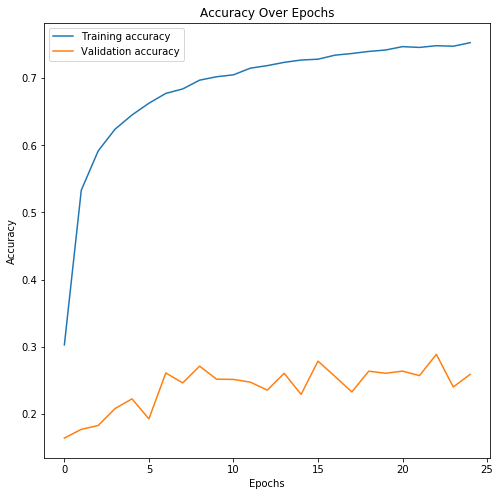

In [126]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_too_much_dropout.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_people_too_much_dropout.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

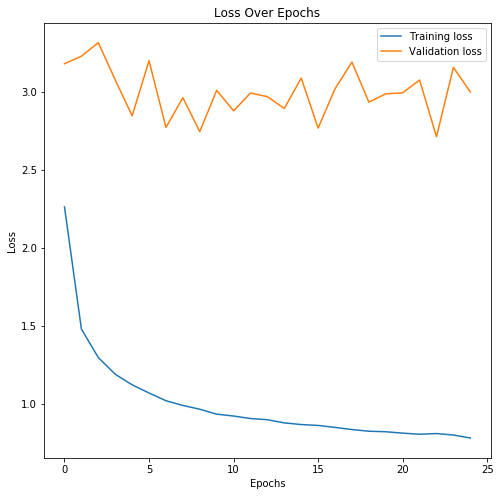

In [127]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_too_much_dropout.history['loss'], label='Training loss')
plt.plot(history_maxpool_people_too_much_dropout.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_maxpool_people_too_much_dropout = model_maxpool_people_too_much_dropout.predict_classes(X_test_std)
y_test_maxpool_people_too_much_dropout = np.argmax(y_test_coded, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_people_too_much_dropout = accuracy_score(y_pred_maxpool_people_too_much_dropout,y_test_maxpool_people_too_much_dropout)
print('the accuracy obtained on the test set is:', accuracy_maxpool_people_too_much_dropout)

the accuracy obtained on the test set is: 0.586762634955406


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_people_too_much_dropout, y_pred_maxpool_people_too_much_dropout))

             precision    recall  f1-score   support

          0       0.51      0.72      0.59       545
          1       0.77      0.99      0.87       534
          2       0.39      0.66      0.49       540
          3       0.46      0.69      0.55       544
          4       0.33      0.27      0.30       539
          5       0.80      0.96      0.87       527
          6       0.57      0.87      0.69       537
          7       0.83      0.35      0.49       534
          8       0.74      0.67      0.71       525
          9       0.95      0.47      0.62       569
         10       0.93      0.82      0.87       514
         11       0.42      0.72      0.53       525
         12       0.45      0.69      0.55       530
         13       0.62      0.41      0.49       532
         14       0.76      0.96      0.85       527
         15       0.32      0.05      0.08       529
         16       0.37      0.25      0.30       562
         17       0.51      0.27      0.36   

In [79]:
#using max pooling(size = 2,2) subsampling layers:
model_maxpool_people_no_dropout = models.Sequential()
model_maxpool_people_no_dropout.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = (32,32,2)))
model_maxpool_people_no_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
model_maxpool_people_no_dropout.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_maxpool_people_no_dropout.add(layers.MaxPool2D(pool_size = (2,2)))
#model_maxpool_no_dropout.add(layers.Dropout(rate = 0.25))
model_maxpool_people_no_dropout.add(layers.Flatten())
model_maxpool_people_no_dropout.add(layers.Dense(256, activation = 'relu'))
#model_maxpool_no_dropout.add(layers.Dropout(rate = 0.5))
model_maxpool_people_no_dropout.add(layers.Dense(24, activation = 'softmax'))

In [ ]:
# compile the model
model_maxpool_people_no_dropout.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [ ]:
#fitting the model
history_maxpool_people_no_dropout = model_maxpool_people_no_dropout.fit(X_train_std, y_train_coded, epochs=25, validation_data=(X_val_std, y_val_coded))

Train on 39675 samples, validate on 13132 samples
Epoch 1/25
39675/39675 [==============================] - 83s 2ms/step - loss: 0.6766 - acc: 0.7952 - val_loss: 4.6473 - val_acc: 0.1815
Epoch 2/25
39675/39675 [==============================] - 49s 1ms/step - loss: 0.1263 - acc: 0.9605 - val_loss: 5.8085 - val_acc: 0.1767
Epoch 3/25
39675/39675 [==============================] - 48s 1ms/step - loss: 0.0638 - acc: 0.9797 - val_loss: 5.9625 - val_acc: 0.1751
Epoch 4/25
39675/39675 [==============================] - 48s 1ms/step - loss: 0.0405 - acc: 0.9867 - val_loss: 6.4511 - val_acc: 0.1959
Epoch 5/25
39675/39675 [==============================] - 66s 2ms/step - loss: 0.0258 - acc: 0.9916 - val_loss: 6.6005 - val_acc: 0.2152
Epoch 6/25
39675/39675 [==============================] - 45s 1ms/step - loss: 0.0296 - acc: 0.9906 - val_loss: 7.3117 - val_acc: 0.1958
Epoch 7/25
39675/39675 [==============================] - 46s 1ms/step - loss: 0.0210 - acc: 0.9934 - val_loss: 7.4155 - val_acc

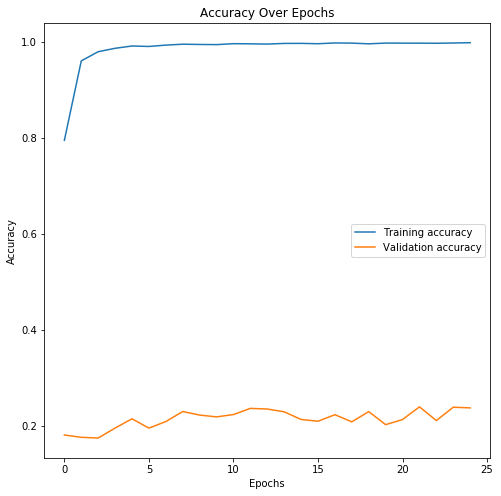

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_no_dropout.history['acc'], label='Training accuracy')
plt.plot(history_maxpool_people_no_dropout.history['val_acc'], label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

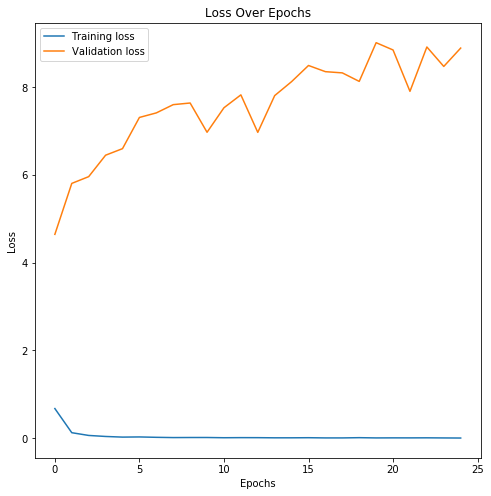

In [128]:
plt.figure(figsize = (8,8))
plt.plot(history_maxpool_people_no_dropout.history['loss'], label='Training loss')
plt.plot(history_maxpool_people_no_dropout.history['val_loss'], label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
y_pred_maxpool_people_no_dropout = model_maxpool_people_no_dropout.predict_classes(X_test_std)
y_test_maxpool_people_no_dropout = np.argmax(y_test_coded, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_maxpool_people_no_dropout = accuracy_score(y_pred_maxpool_people_no_dropout,y_test_maxpool_people_no_dropout)
print('the accuracy obtained on the test set is:', accuracy_maxpool_people_no_dropout)

the accuracy obtained on the test set is: 0.5571115631356596


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test_maxpool_people_no_dropout, y_pred_maxpool_people_no_dropout))

             precision    recall  f1-score   support

          0       0.55      0.79      0.64       545
          1       0.64      0.99      0.78       534
          2       0.40      0.94      0.56       540
          3       0.78      0.56      0.66       544
          4       0.14      0.07      0.10       539
          5       0.73      0.82      0.77       527
          6       0.59      0.58      0.58       537
          7       0.88      0.41      0.55       534
          8       0.66      0.61      0.63       525
          9       0.63      0.18      0.28       569
         10       0.83      0.59      0.69       514
         11       0.52      0.52      0.52       525
         12       0.54      0.77      0.64       530
         13       0.43      0.67      0.52       532
         14       0.82      0.42      0.55       527
         15       0.07      0.01      0.01       529
         16       0.35      0.25      0.29       562
         17       0.85      0.56      0.68   